# Exercise: Feature extraction

## Task 1:
Load the skimage built-in images 'coins' and represent the coins that have a eccentricity larger and lower than the average.



Average eccentricity: 0.377


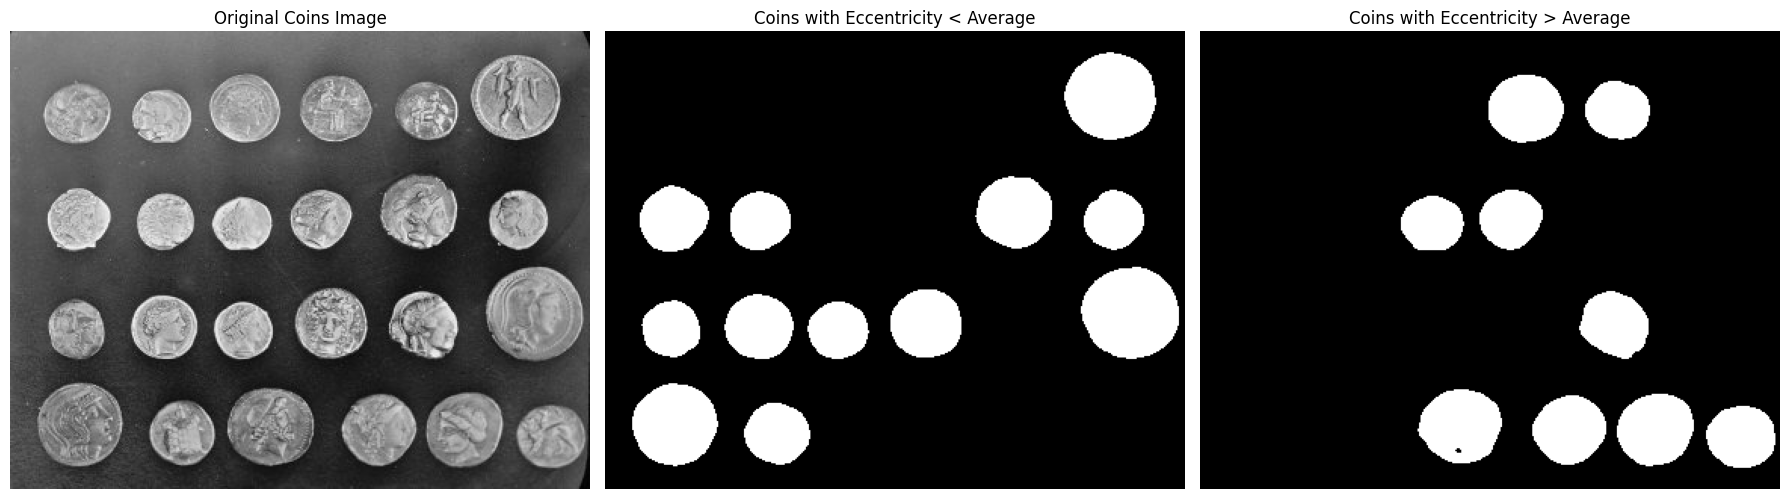

In [60]:
from skimage import data, filters, morphology
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
import numpy as np

Coins = data.coins()

# preprocess: Gaussian smooth & Otsu threshold
blur = filters.gaussian(Coins, sigma=2)
thresh = filters.threshold_otsu(blur)
binary = blur > thresh

# clean up binary mask (remove small artifacts and borders)
binary = morphology.remove_small_objects(binary, 50) # removes tiny noise blobs that aren’t coins.
binary = clear_border(binary) # removes any objects touching the border

# label connected components (coins)
label_image = label(binary)

# measure region properties
regions = regionprops(label_image)

# compute eccentricities
eccentricities = [r.eccentricity for r in regions]
avg_ecc = np.mean(eccentricities)
print(f"Average eccentricity: {avg_ecc:.3f}")

# create masks for coins above/below average
high_ecc_mask = np.zeros_like(label_image, dtype=bool) # more elongated than average
low_ecc_mask = np.zeros_like(label_image, dtype=bool) # rounder than average

for r in regions:
    if r.eccentricity > avg_ecc:
        high_ecc_mask[label_image == r.label] = True
    else:
        low_ecc_mask[label_image == r.label] = True

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

axes[0].imshow(Coins, cmap='gray')
axes[0].set_title("Original Coins Image")
axes[0].axis('off')

axes[1].imshow(low_ecc_mask, cmap='gray')
axes[1].set_title("Coins with Eccentricity < Average")
axes[1].axis('off')

axes[2].imshow(high_ecc_mask, cmap='gray')
axes[2].set_title("Coins with Eccentricity > Average")
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Task 2:

Repeat task 1 with the skimage built-in images 'page'.


Average eccentricity: 0.914


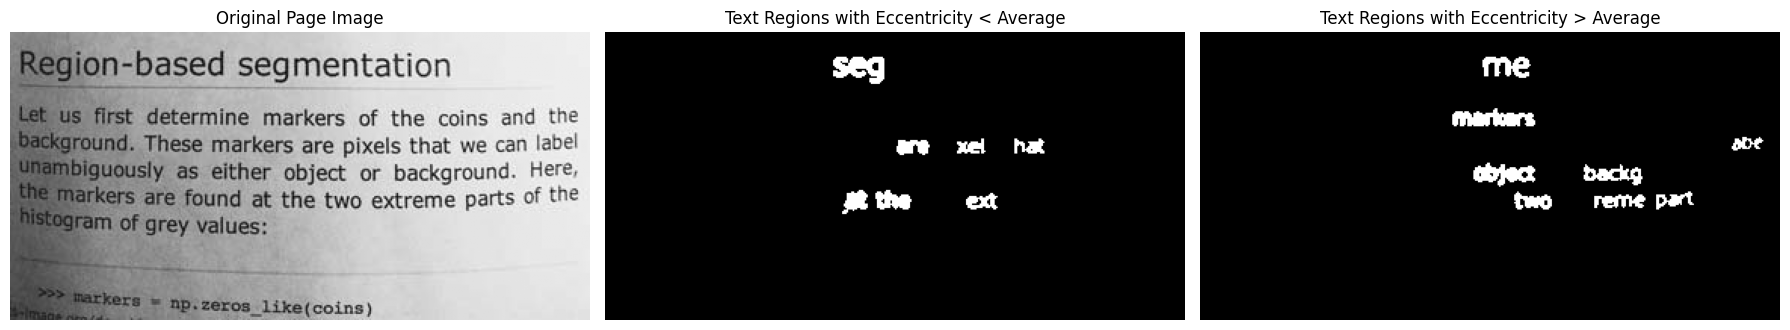

In [61]:
page = data.page()

blur = filters.gaussian(page, sigma=1)
thresh = filters.threshold_otsu(blur)
binary = blur < thresh   # invert since text is darker than background

binary = morphology.remove_small_objects(binary, 100)
binary = clear_border(binary)

label_image = label(binary)
regions = regionprops(label_image)

eccentricities = [r.eccentricity for r in regions if r.area > 100]  # filter out tiny specks
avg_ecc = np.mean(eccentricities)
print(f"Average eccentricity: {avg_ecc:.3f}")

high_ecc_mask = np.zeros_like(label_image, dtype=bool)
low_ecc_mask = np.zeros_like(label_image, dtype=bool)

for r in regions:
    if r.area > 100:  # skip tiny noise
        if r.eccentricity > avg_ecc:
            high_ecc_mask[label_image == r.label] = True
        else:
            low_ecc_mask[label_image == r.label] = True

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

axes[0].imshow(page, cmap='gray')
axes[0].set_title("Original Page Image")
axes[0].axis('off')

axes[1].imshow(low_ecc_mask, cmap='gray')
axes[1].set_title("Text Regions with Eccentricity < Average")
axes[1].axis('off')

axes[2].imshow(high_ecc_mask, cmap='gray')
axes[2].set_title("Text Regions with Eccentricity > Average")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Task 3:
Consider  the function 'binary_blobs' from skimage to generate binary random blobs. Explore the effect of parameters 'blob_size_fraction' and 'volume_fraction'.

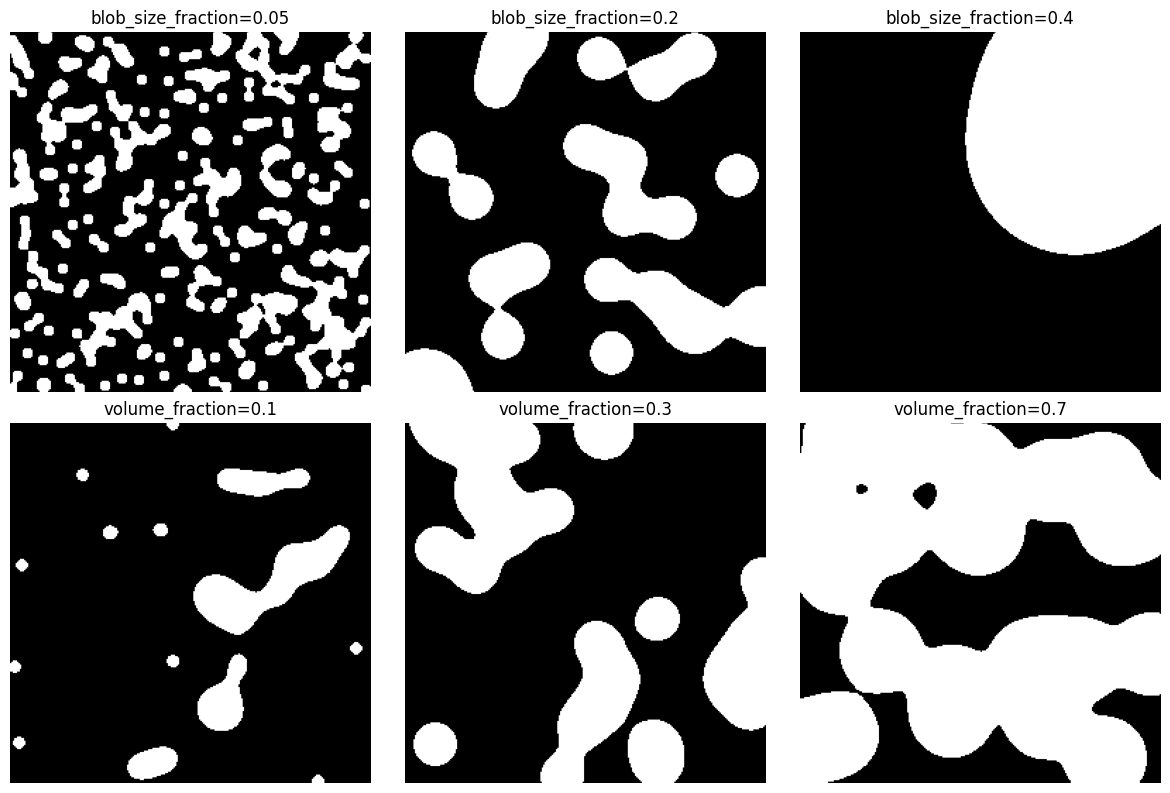

In [62]:
from skimage.data import binary_blobs

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

# blob_size_fraction changing, volume_fraction constant
sizes = [0.05, 0.2, 0.4] # small, medium, large blobs
for i, s in enumerate(sizes):
    blobs = binary_blobs(length=256, blob_size_fraction=s, volume_fraction=0.3)
    axes[i].imshow(blobs, cmap='gray')
    axes[i].set_title(f'blob_size_fraction={s}')
    axes[i].axis('off')

# volume_fraction changing, blob_size_fraction constant
fractions = [0.1, 0.3, 0.7] # prpogressive change of white area
for i, v in enumerate(fractions):
    blobs = binary_blobs(length=256, blob_size_fraction=0.2, volume_fraction=v)
    axes[i+3].imshow(blobs, cmap='gray')
    axes[i+3].set_title(f'volume_fraction={v}')
    axes[i+3].axis('off')

plt.tight_layout()
plt.show()

The two key parameters, `blob_size_fraction` and `volume_fraction`, control different aspects of the image.

The blob_size_fraction parameter determines the relative size of the blobs compared to the image dimensions — smaller values produce many fine, detailed blobs, while larger values yield fewer, smoother, and larger shapes.

In contrast, the volume_fraction parameter controls how much of the image area is occupied by the foreground (white blobs), with low values resulting in sparse distributions and high values producing dense, filled patterns.

Different numeric ranges are chosen for these parameters because they affect the image in distinct ways: **blob_size_fraction influences scale, whereas volume_fraction influences density.**

## Task 4:

Generate an image with binary_blobs.
Obtain the regions through binarization.
Extract 7 diffent regional attributes features.


### Image generation and visualization

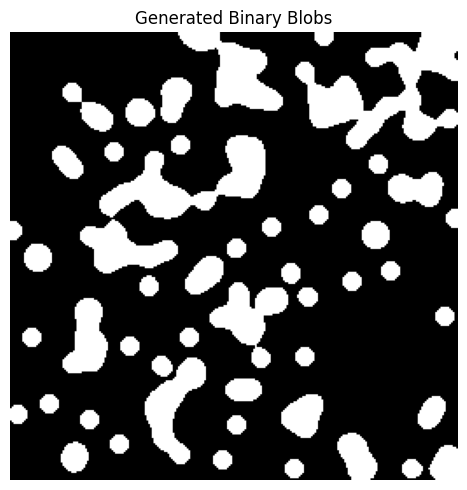

In [63]:
IG = binary_blobs(length=256, blob_size_fraction=0.08, volume_fraction=0.25)

plt.figure(figsize=(5, 5))
plt.imshow(IG, cmap='gray')
plt.title('Generated Binary Blobs')
plt.axis('off')
plt.tight_layout()
plt.show()


### Segmentation and labeling

/usr/local/lib/python3.12/dist-packages/skimage/exposure/exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


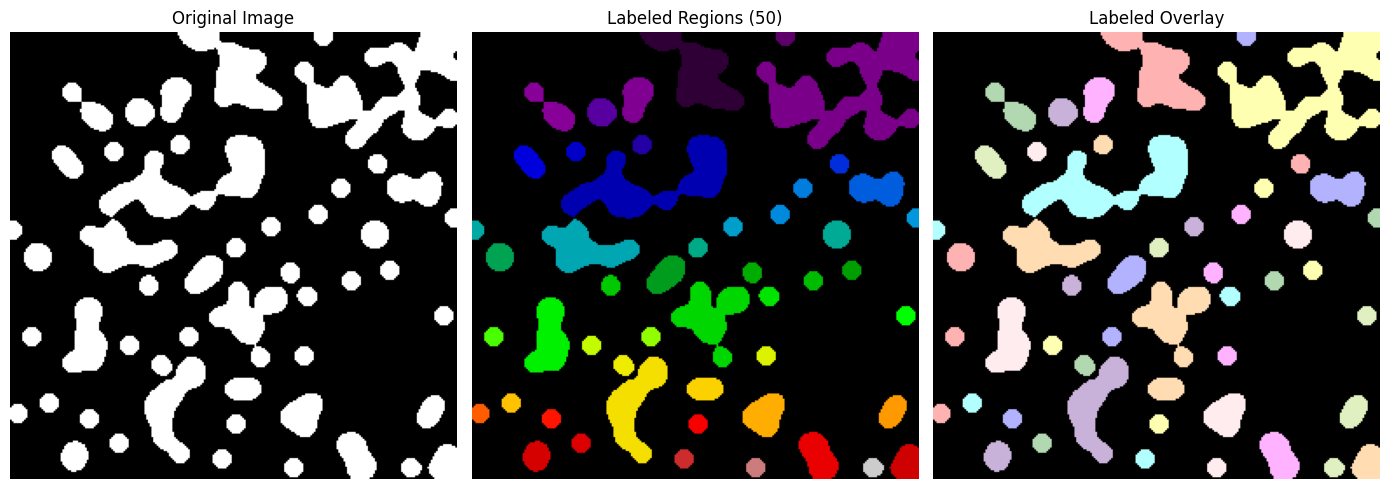

In [64]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

# apply Otsu threshold (though image is already binary)
thresh = threshold_otsu(IG)
bw = IG > thresh

# label connected regions
label_image, nregions = label(bw, return_num=True)
image_label_overlay = label2rgb(label_image, image=IG)

# display segmentation results
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
ax = axes.ravel()

ax[0].imshow(IG, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(label_image, cmap='nipy_spectral')
ax[1].set_title(f'Labeled Regions ({nregions})')
ax[2].imshow(image_label_overlay)
ax[2].set_title('Labeled Overlay')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

### 7 regional attributes extraction

In [65]:
from skimage import measure
import pandas as pd

props = measure.regionprops_table(
    label_image,
    properties=[
        'label',
        'area',
        'eccentricity',
        'extent',
        'perimeter',
        'solidity',
        'orientation',
        'major_axis_length'
    ]
)

# convert to DataFrame
df_features = pd.DataFrame(props)
print("Extracted region features:")
display(df_features.head())

Extracted region features:


,label,area,eccentricity,extent,perimeter,solidity,orientation,major_axis_length
0,1,1254.0,0.872447,0.464444,201.539105,0.719449,0.788802,65.214888
1,2,76.0,0.685172,0.863636,30.485281,1.000000,-1.570796,11.679942
2,3,2741.0,0.811476,0.439897,496.274170,0.560532,-1.235283,106.221203
3,4,352.0,0.802525,0.752137,72.526912,0.936170,-0.284727,27.842903
4,5,339.0,0.943732,0.417488,91.597980,0.795775,0.817047,40.334472


## Task 5:

Using sk.learn (or any other library), determine the most relevant feature/regional attribute. You can use communality in feature space or any other criteria that you find interesting to determine the most relevant.

In [66]:
from sklearn.ensemble import RandomForestClassifier

# define target: large vs small blobs
mean_area = df_features['area'].mean()
df_features['large'] = df_features['area'] >= mean_area  # True = large, False = small

# feature matrix and target
X = df_features.drop(columns=['label','large'])
y = df_features['large']

# train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# extract feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature importance from Random Forest:")
display(importances)

Feature importance from Random Forest:


,0
major_axis_length,0.254407
area,0.248779
perimeter,0.211889
solidity,0.114174
extent,0.092053
eccentricity,0.074920
orientation,0.003778


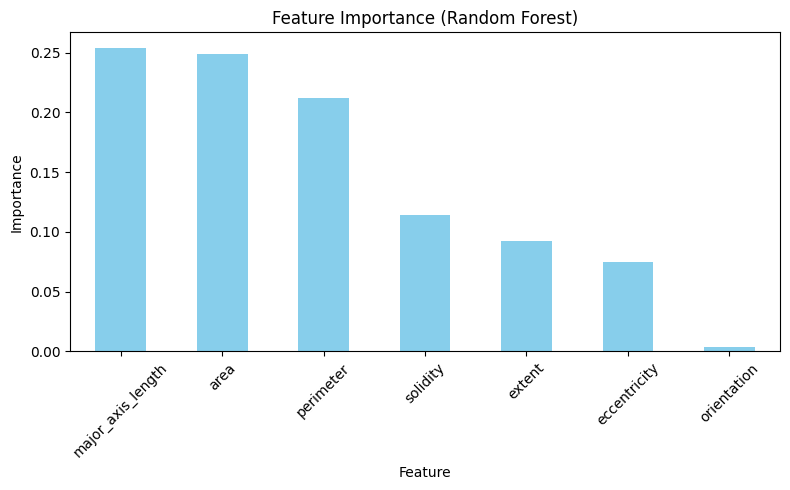

In [67]:
plt.figure(figsize=(8,5))
importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To determine the most relevant regional attribute among the seven extracted features, a Random Forest classifier was trained to distinguish blobs larger than the mean area from smaller blobs. The resulting feature importance scores indicate which attributes are most informative for predicting blob size. Features such as area, major_axis_length, and perimeter were identified as the most relevant, highlighting their key role in describing the structural variability of the synthetic binary blobs. This supervised approach provides a clear and interpretable measure of feature relevance, outperforming unsupervised variance-based methods.

**Team Members**:
- Apostolia Maria Sofianopoulou
- Paula Eva Wagner
- Sandra Catalina Parra Navarrete